# Common imports

In [183]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

%load_ext autoreload
%autoreload 2

# Provided functions
### Image loading and saving

In [4]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        # Parse light source directions from filename
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        # Parse sphere coor -> cartesian coor
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm')) # load ambient image
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm')) # load image list
    if num_images <= len(im_list): 
        im_sub_list = np.random.choice(im_list, num_images, replace=False) # choose sublist to use
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1) # stacked images data
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list]) # stacked light sources data

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [5]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [283]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(10, 90)
    ax.mouse_init(rotate_btn=1, zoom_btn=3)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [278]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [279]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed_imarray = np.clip(imarray - ambimage[:,:,np.newaxis], a_min = 0, a_max = None).astype(float)
    np.true_divide(processed_imarray, processed_imarray.max(), out=processed_imarray)
    return processed_imarray

In [280]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    #g = np.zeros((3, 192*168))
    V = light_dirs
    I = imarray.transpose(2,0,1).reshape(imarray.shape[2], -1)
    g = np.linalg.lstsq(V, I, rcond=None)[0].transpose(1,0)
    ro = np.sqrt(np.einsum('...i,...i', g, g))    
    surface_normals = (g/(ro[:,None])).reshape(192, 168, 3)
    albedo_image = ro.reshape(192, 168)
    return albedo_image, surface_normals

In [286]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    fx = surface_normals[:,:,0]/surface_normals[:,:,2]
    fy = surface_normals[:,:,1]/surface_normals[:,:,2]
    rh = np.cumsum(fx, axis=1)[0] + np.cumsum(fy, axis=0)
    ch = np.cumsum(fx, axis=1) + np.cumsum(fy, axis=0)[0]
    if integration_method == 'row':
        return rh
    elif integration_method == 'column':
        return ch
    elif integration_method == 'average':
        return (ch+rh)/2
    elif integration_method == 'random':
        height_maps = []
        PATH_COUNT = 10
        for i in range(PATH_COUNT):
            height_maps.append(np.zeros([fx.shape[0], fx.shape[1]]))
        for r in range(fx.shape[0]):
            for c in range(fx.shape[1]):
                path_arr = np.append(np.ones(r), np.zeros(c))
                for i in range(PATH_COUNT):
                    np.random.shuffle(path_arr)
                    r_cur = r
                    c_cur = c
                    for di in path_arr:
                        if di == 1:
                            height_maps[i][r][c] += fy[r_cur][c_cur]
                            r_cur -= 1
                        else:
                            height_maps[i][r][c] += fx[r_cur][c_cur]
                            c_cur -= 1
        
        return np.sum(height_maps, axis=0)/PATH_COUNT

# Main function

--- 98.2272720336914 seconds ---


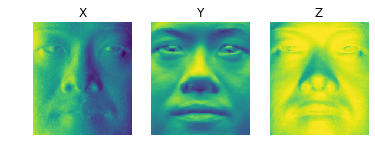

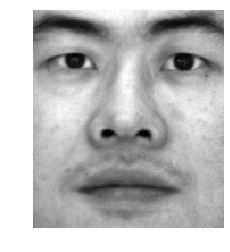

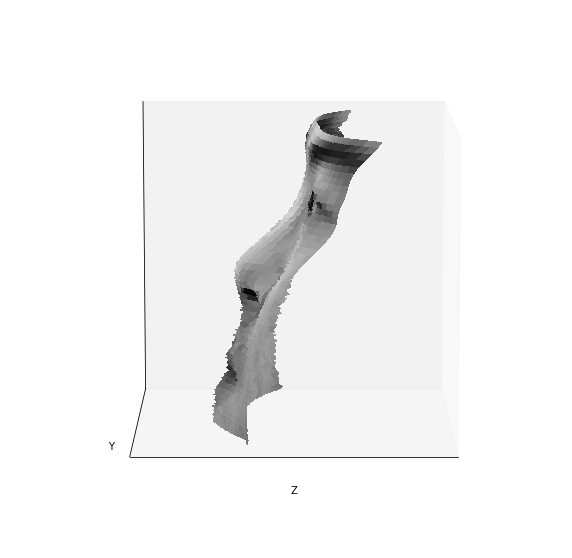

In [288]:
root_path = './croppedyale/'
#subject_names = ['yaleB02', 'yaleB05', 'yaleB05', 'yaleB07']
#integration_methods = ['row', 'column', 'average', 'random']

subject_names = ['yaleB02']
integration_methods = ['random']
save_flag = True


for subject_name in subject_names:
    
    full_path = '%s%s' % (root_path, subject_name)
    
    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)
    processed_imarray = preprocess(ambient_image, imarray)
    albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
    plot_surface_normals(surface_normals)
    
    import time
    
    for integration_method in integration_methods:
        start_time = time.time()
        height_map = get_surface(surface_normals, integration_method)
        print("--- %s seconds ---" % (time.time() - start_time))
        display_output(albedo_image, height_map)
    
    if save_flag:
        save_outputs(subject_name, albedo_image, surface_normals)

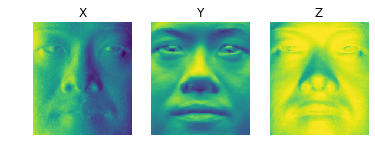

In [289]:
plot_surface_normals(surface_normals)

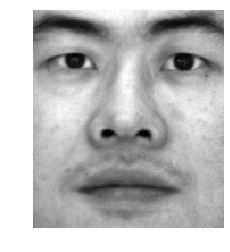

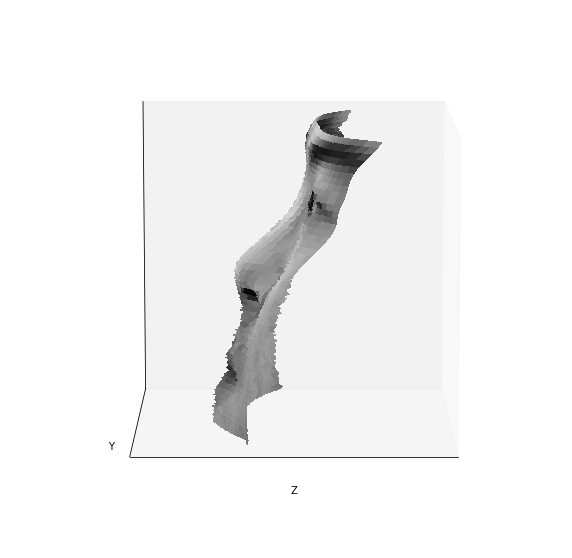

In [290]:
display_output(albedo_image, height_map)